In [1]:
# !pip uninstall tensorflow tensorflow-tensorboard tensorflow-estimator
!pip install gdown
!pip install tensorflow-gpu

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-4.5.1-py3-none-any.whl size=14933 sha256=6b01cc6c6c4fb37e6d31af8ac4fd843919c9765b291fb803af16eaddeaa4b55d
  Stored in directory: /home/jovyan/.cache/pip/wheels/8d/df/71/846b2aa0fabaac2af23fbc5214eeaa55f0616e9d1a05187d72
Successfully built gdown
     |████████████████████████████████| 511.7 MB 9.8 kB/s eta 0:00:017   |███▊                            | 59.6 MB 4.3 MB/s eta 0:01:47
     |████████████████████████████████| 123 kB 3.0 MB/s eta 0:00:01
     |████████████████████████████████| 57 kB 136 kB/s eta 0:00:01
     |████████████████████████████████| 4.5 MB 4.4 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 3.8 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 41 kB/s  eta 0:00:01
     |████████████████████████████████| 14.5 MB 36 kB/s  eta 0:00:01
     |████████████████████████████████| 17.

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [4]:
df = pd.read_csv(
  "/home/jovyan/work/model/training_data/rf_training_data1.csv", 
  parse_dates=['read_date'], 
  index_col="read_date"
)

df.shape

(1750, 18)

In [5]:
df = df.drop(['bl_meter1','bl_ahd1','bl_meter2','bl_ahd2','bl_meter3','bl_ahd3','mean_temp3','bl_meter4','bl_ahd4','mean_temp4','sl_meter','rf_meter','mean_temp1','mean_temp2'
             ],axis=1)

In [6]:
# Remove non representative data 1. Laucie Letch pumping episode, 2. Bad reads end of 2020
# WHERE  
#                        `A`.`meter_no` = "GW967137.1.1" AND `A`.`read_date` NOT BETWEEN '2008-01-31' AND '2008-09-01'
#                            AND `A`.`read_date` NOT BETWEEN '2020-12-13' AND '2021-01-01'
# filtered_df = df.loc[(df['date'] >= '2020-09-01') 
#                     & (df['date'] < '2020-09-15')] 
# df1 = df1_orig[df1_orig['read_date'] >= '2005-11-17'] 

# df = df_orig.loc[(df_orig['read_date'] > '2008-01-31') 
#                 & (df_orig['read_date'] <= '2008-09-01')
#                 & (df_orig['read_date'] > '2020-12-13')
#                 & (df_orig['read_date'] <= '2021-01-01')]                              # Elfin Crossing Data
# 
# df.shape

In [7]:
# Feature engineering. 1. Add moving ave for rainfall 2. Add bins every 40 mm of rainfall 3. Drop NaNs

df['rf_MA90'] = (df['rf_read1'].rolling(window=90).mean())

df['rf_bin'] = pd.cut(
    df['rf_MA90'],
    bins=[-1,40,80,120,160],                             
    labels=[1,2,3,4],
    include_lowest=True
    )

df.dropna(inplace=True)

In [8]:
df.shape

(1661, 5)

In [9]:
df.head()

,sl_read1,rf_read1,rf_MA,rf_bin,rf_MA90
read_date,,,,,
2006-10-19,0.187,4.4,0.44,1,7.488889
2006-10-20,0.186,0.6,0.50,1,7.455556
2006-10-21,0.190,19.8,2.48,1,7.206667
2006-10-22,0.192,0.2,2.50,1,7.053333
2006-10-26,0.186,2.6,2.76,1,7.068889


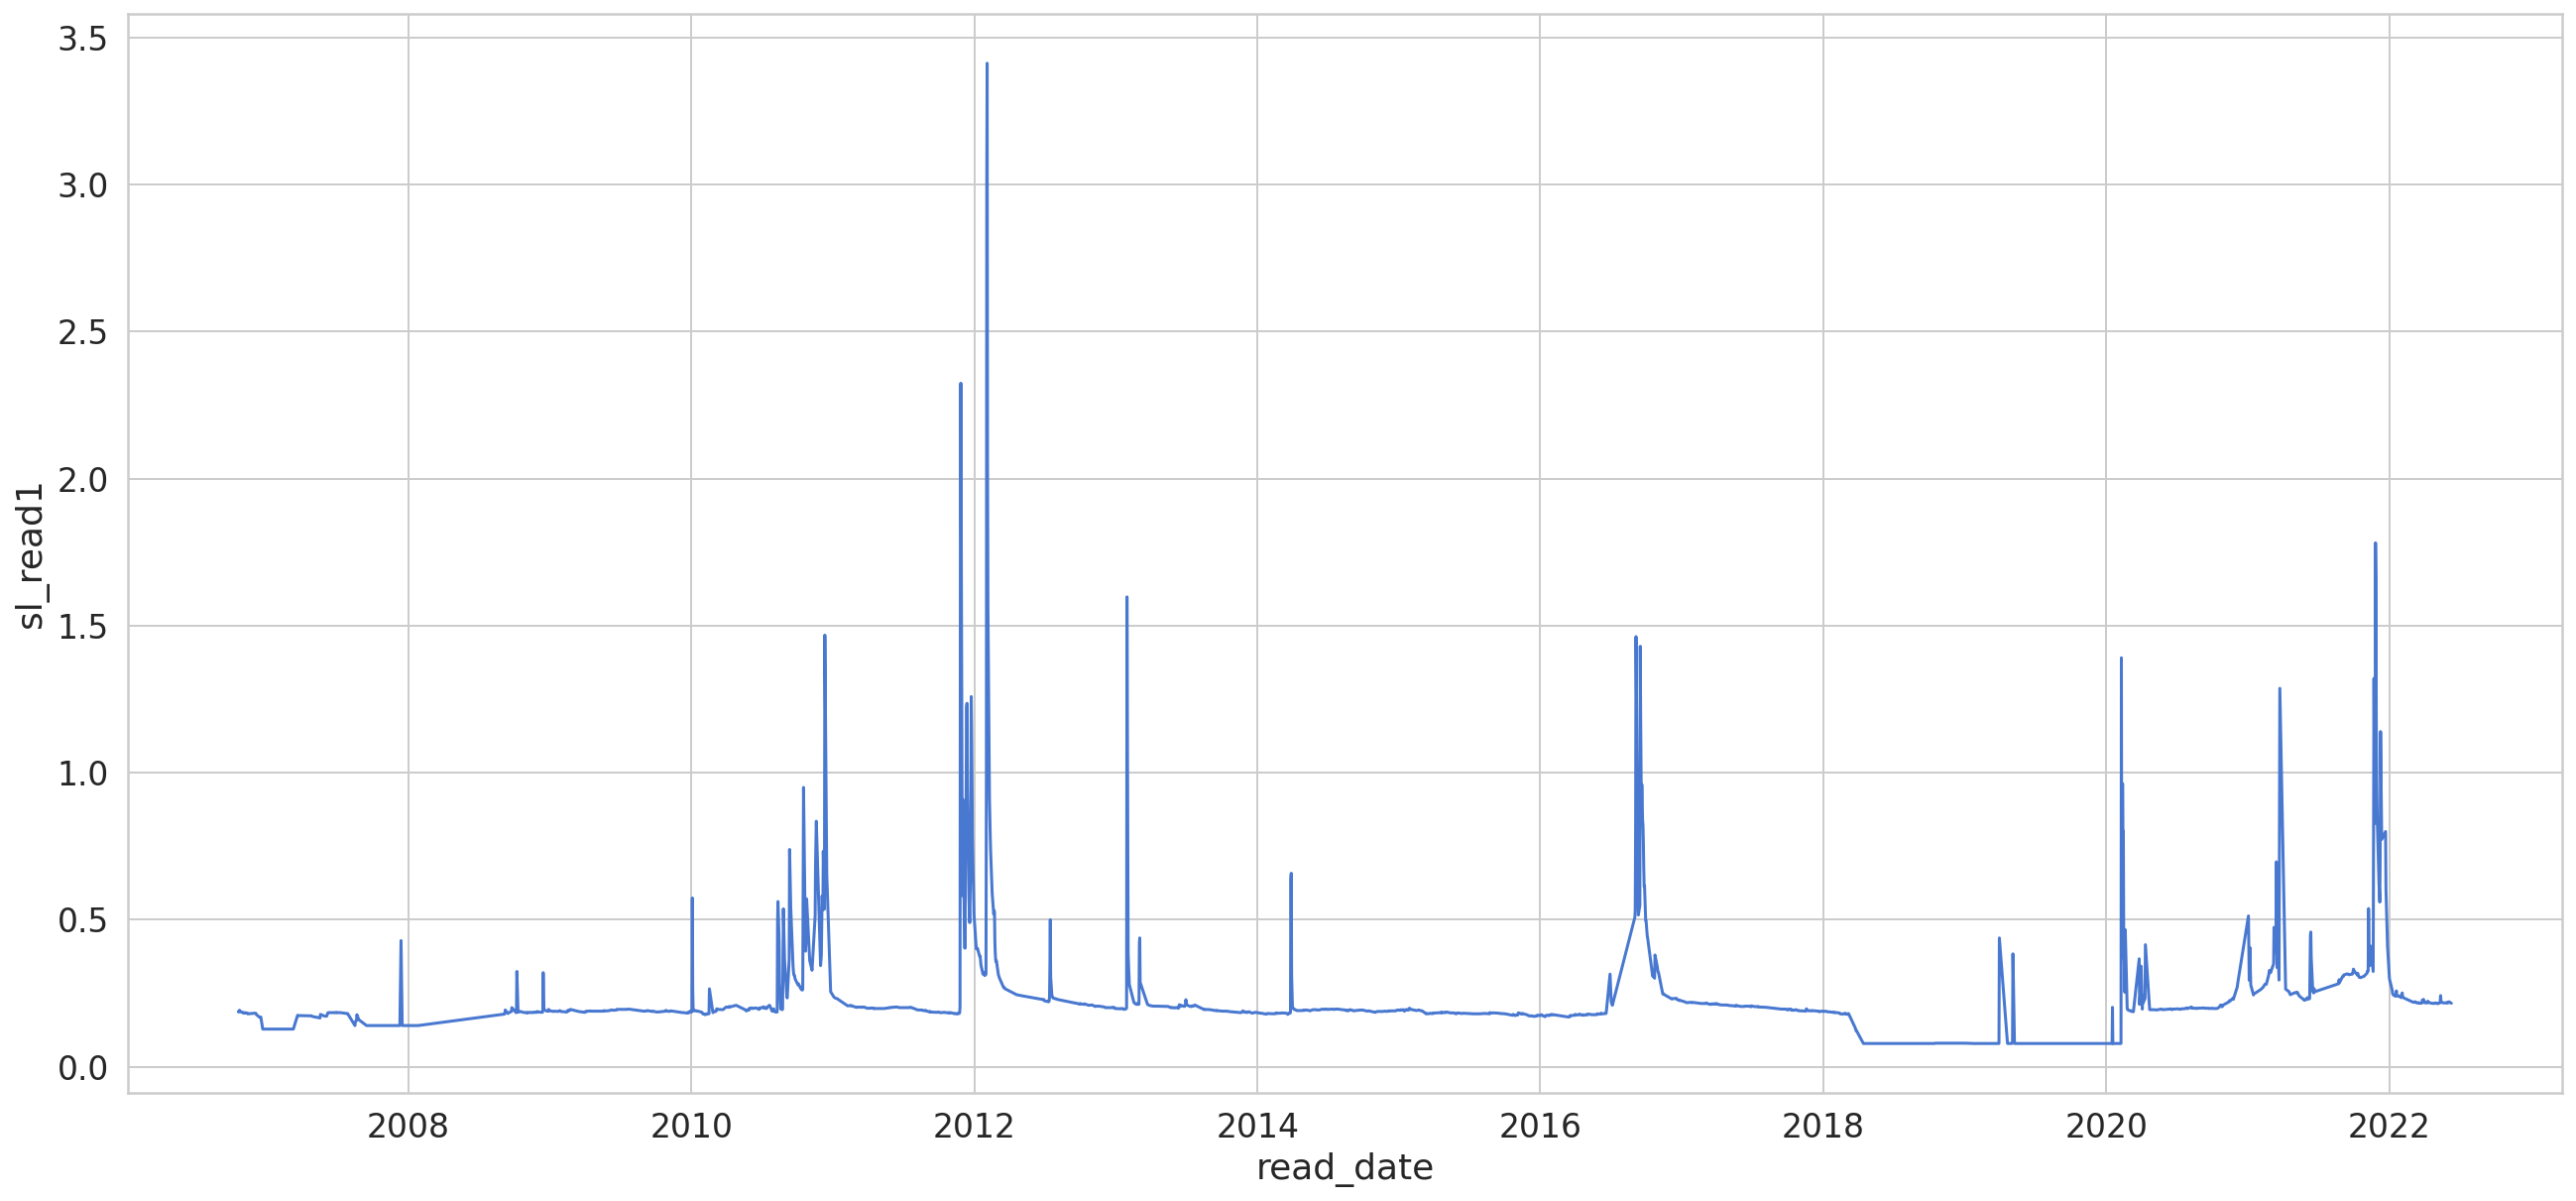

In [10]:
sns.lineplot(x=df.index, y="sl_read1", data=df);

In [11]:
train_size = int(len(df) * 0.75)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

1245 416


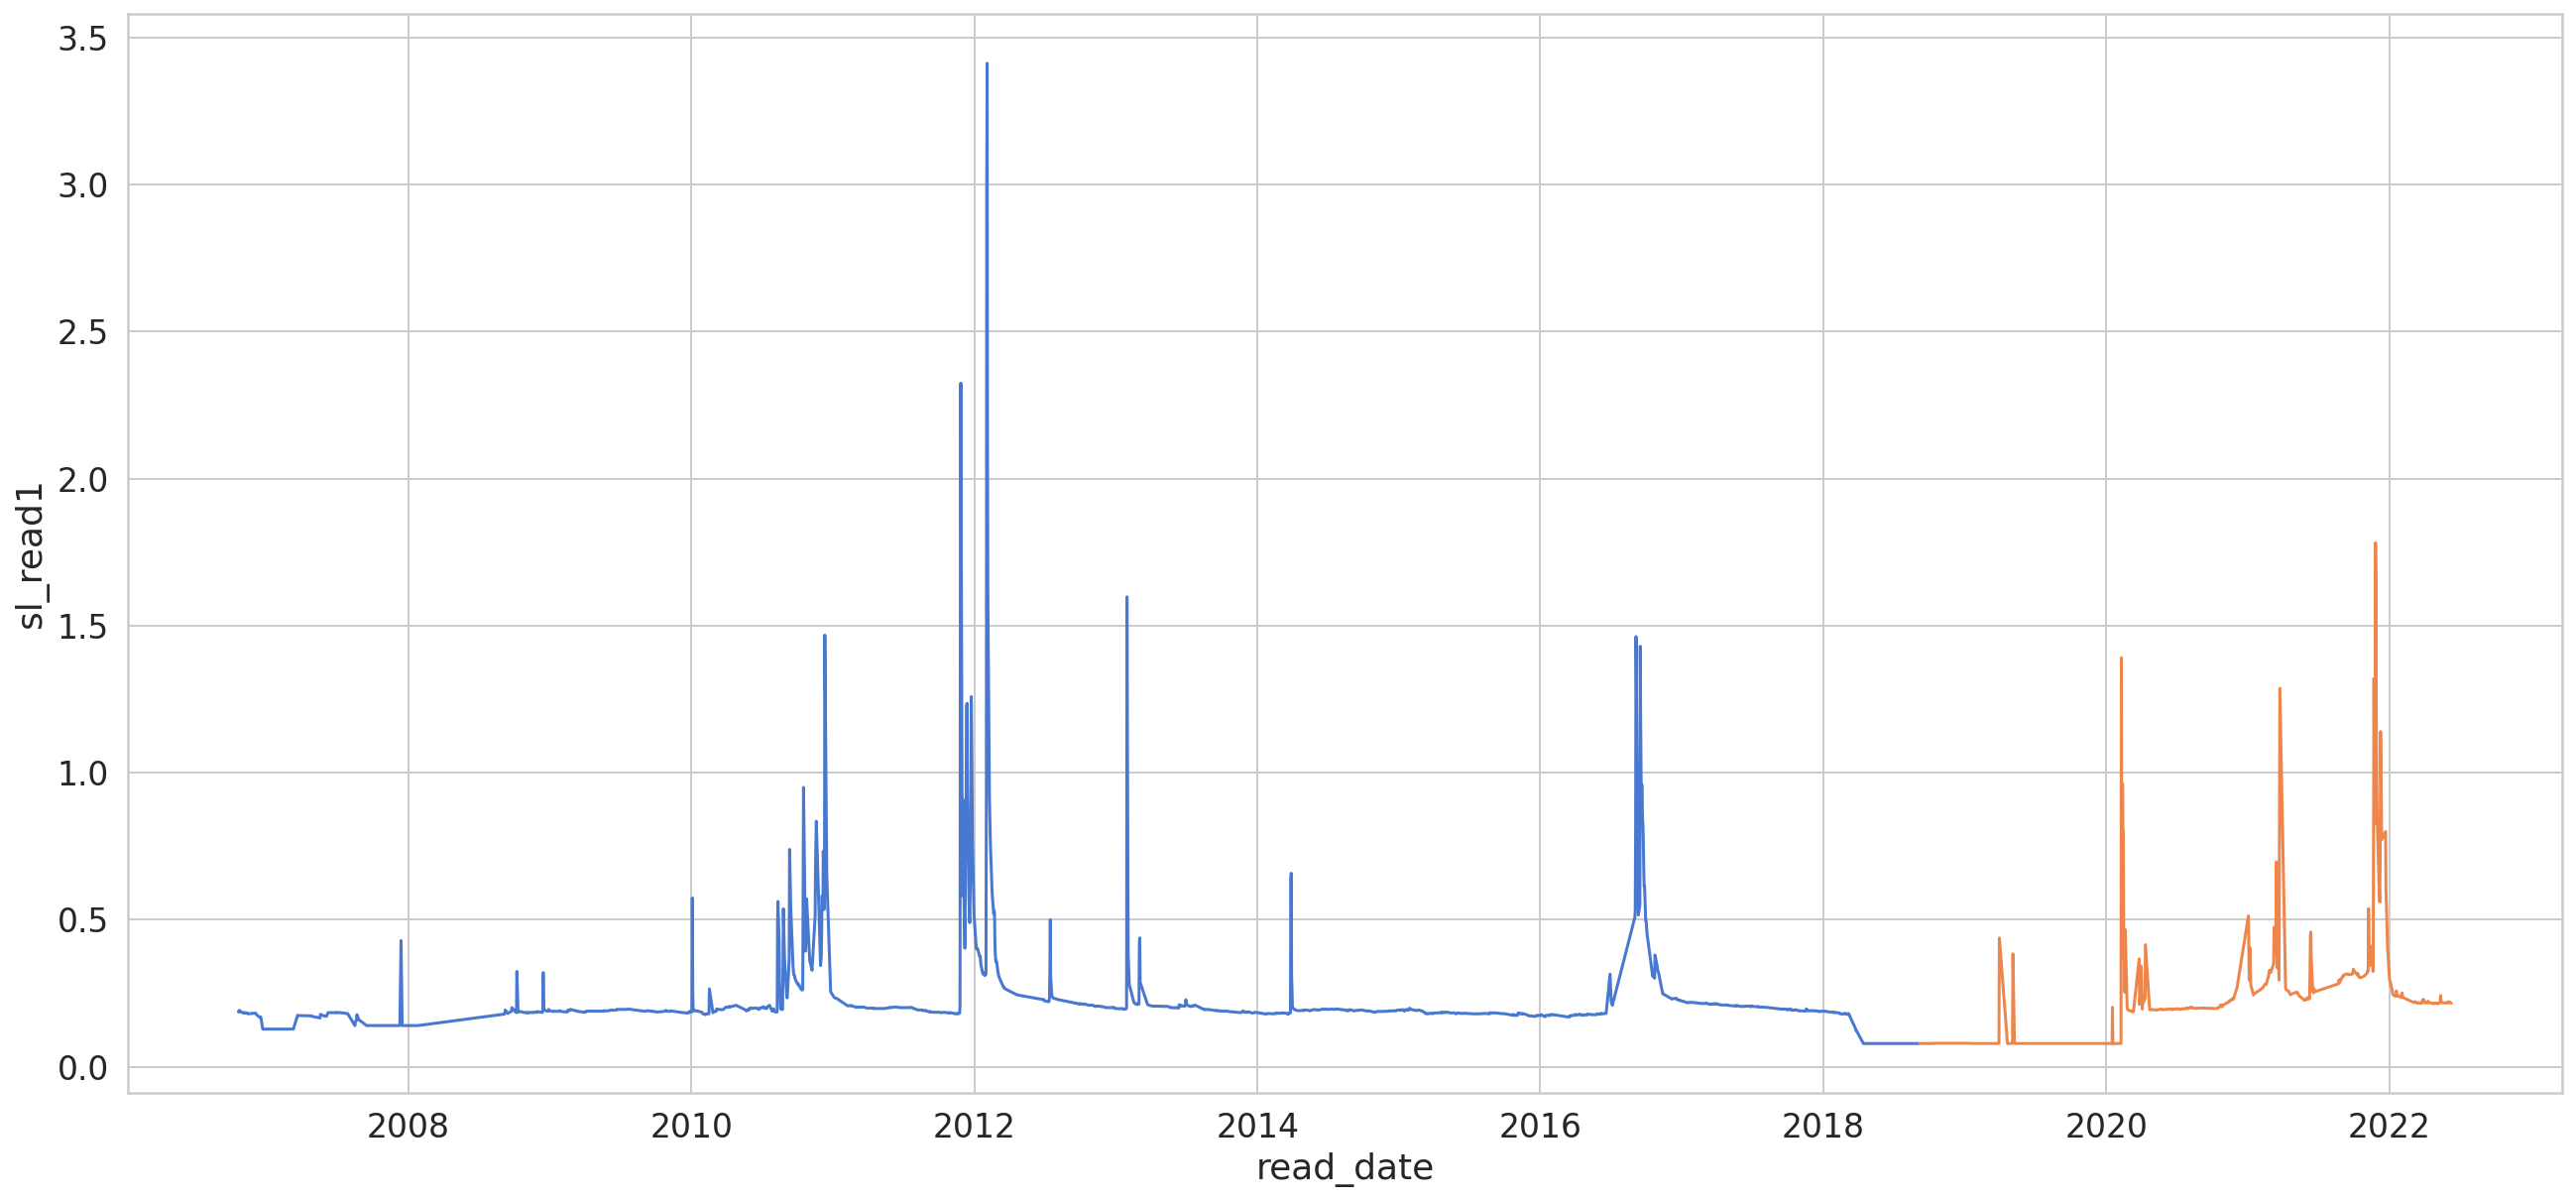

In [12]:
sns.lineplot(x=train.index, y="sl_read1", data=train);
sns.lineplot(x=test.index, y="sl_read1", data=test);

In [13]:
from sklearn.preprocessing import RobustScaler

#f_columns = ['t1', 't2', 'hum', 'wind_speed']
f_columns = ['rf_read1','rf_MA90','rf_bin']

f_transformer = RobustScaler()
sl_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
sl_transformer = sl_transformer.fit(train[['sl_read1']])

train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train['sl_read1'] = sl_transformer.transform(train[['sl_read1']])

test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test['sl_read1'] = sl_transformer.transform(test[['sl_read1']])


#from sklearn.preprocessing import RobustScaler
#
#f_columns = ['t1', 't2', 'hum', 'wind_speed']
#
#f_transformer = RobustScaler()
#cnt_transformer = RobustScaler()
#
#f_transformer = f_transformer.fit(train[f_columns].to_numpy())
#cnt_transformer = cnt_transformer.fit(train[['cnt']])
#
#train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
#train['cnt'] = cnt_transformer.transform(train[['cnt']])
#
#test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
#test['cnt'] = cnt_transformer.transform(test[['cnt']])


/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
<ipython-input-13-9eefe70500d4>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['sl_read1'] = sl_transformer.transform(train[['sl_read1']])
/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

In [14]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [15]:
time_steps = 10

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.sl_read1, time_steps)
X_test, y_test = create_dataset(test, test.sl_read1, time_steps)

print(X_train.shape, y_train.shape)

(1235, 10, 5) (1235,)


In [16]:
model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128, 
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [17]:
history = model.fit(
    X_train, y_train, 
    epochs=40, 
    batch_size=32, 
    validation_split=0.1,
    shuffle=False
)

Epoch 1/40
35/35 [==============================] - 3s 22ms/step - loss: 83.1103 - val_loss: 0.9622
Epoch 2/40
35/35 [==============================] - 0s 7ms/step - loss: 69.6950 - val_loss: 1.0723
Epoch 3/40
35/35 [==============================] - 0s 7ms/step - loss: 60.5353 - val_loss: 1.8258
Epoch 4/40
35/35 [==============================] - 0s 8ms/step - loss: 55.7705 - val_loss: 2.0729
Epoch 5/40
35/35 [==============================] - 0s 8ms/step - loss: 52.6114 - val_loss: 1.8017
Epoch 6/40
35/35 [==============================] - 0s 7ms/step - loss: 49.2943 - val_loss: 1.8375
Epoch 7/40
35/35 [==============================] - 0s 8ms/step - loss: 47.8643 - val_loss: 1.6494
Epoch 8/40
35/35 [==============================] - 0s 7ms/step - loss: 45.9253 - val_loss: 1.6420
Epoch 9/40
35/35 [==============================] - 0s 7ms/step - loss: 46.3252 - val_loss: 1.3534
Epoch 10/40
35/35 [==============================] - 0s 7ms/step - loss: 45.2983 - val_loss: 1.8203
Epoch 11

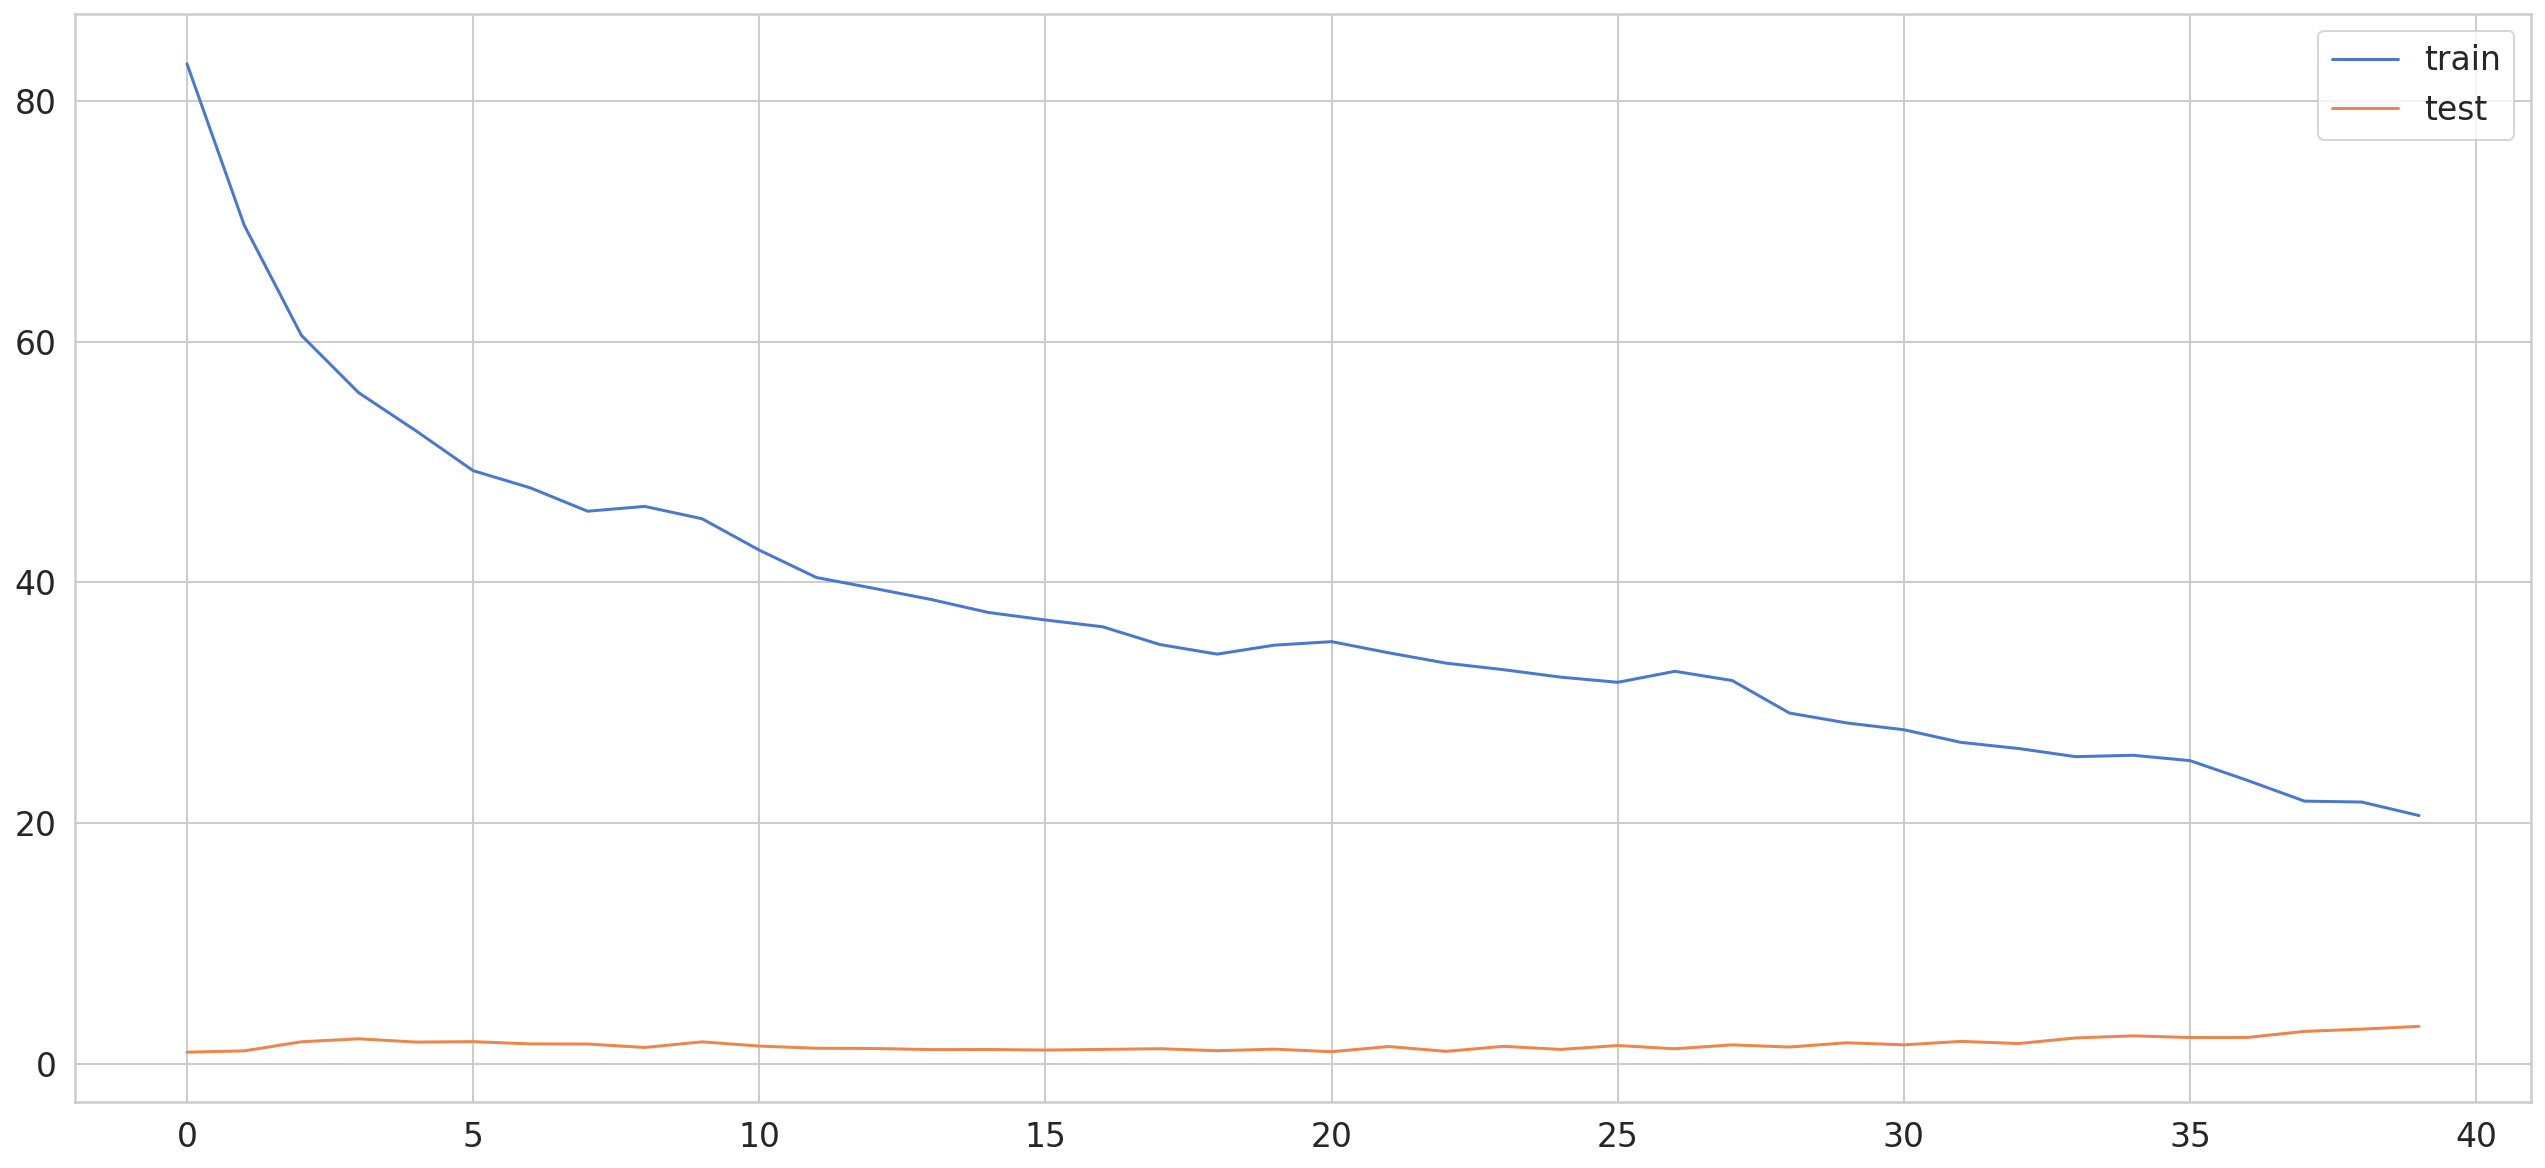

In [18]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [19]:
y_pred = model.predict(X_test)

13/13 [==============================] - 1s 3ms/step


In [20]:
y_train_inv = sl_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = sl_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = sl_transformer.inverse_transform(y_pred)

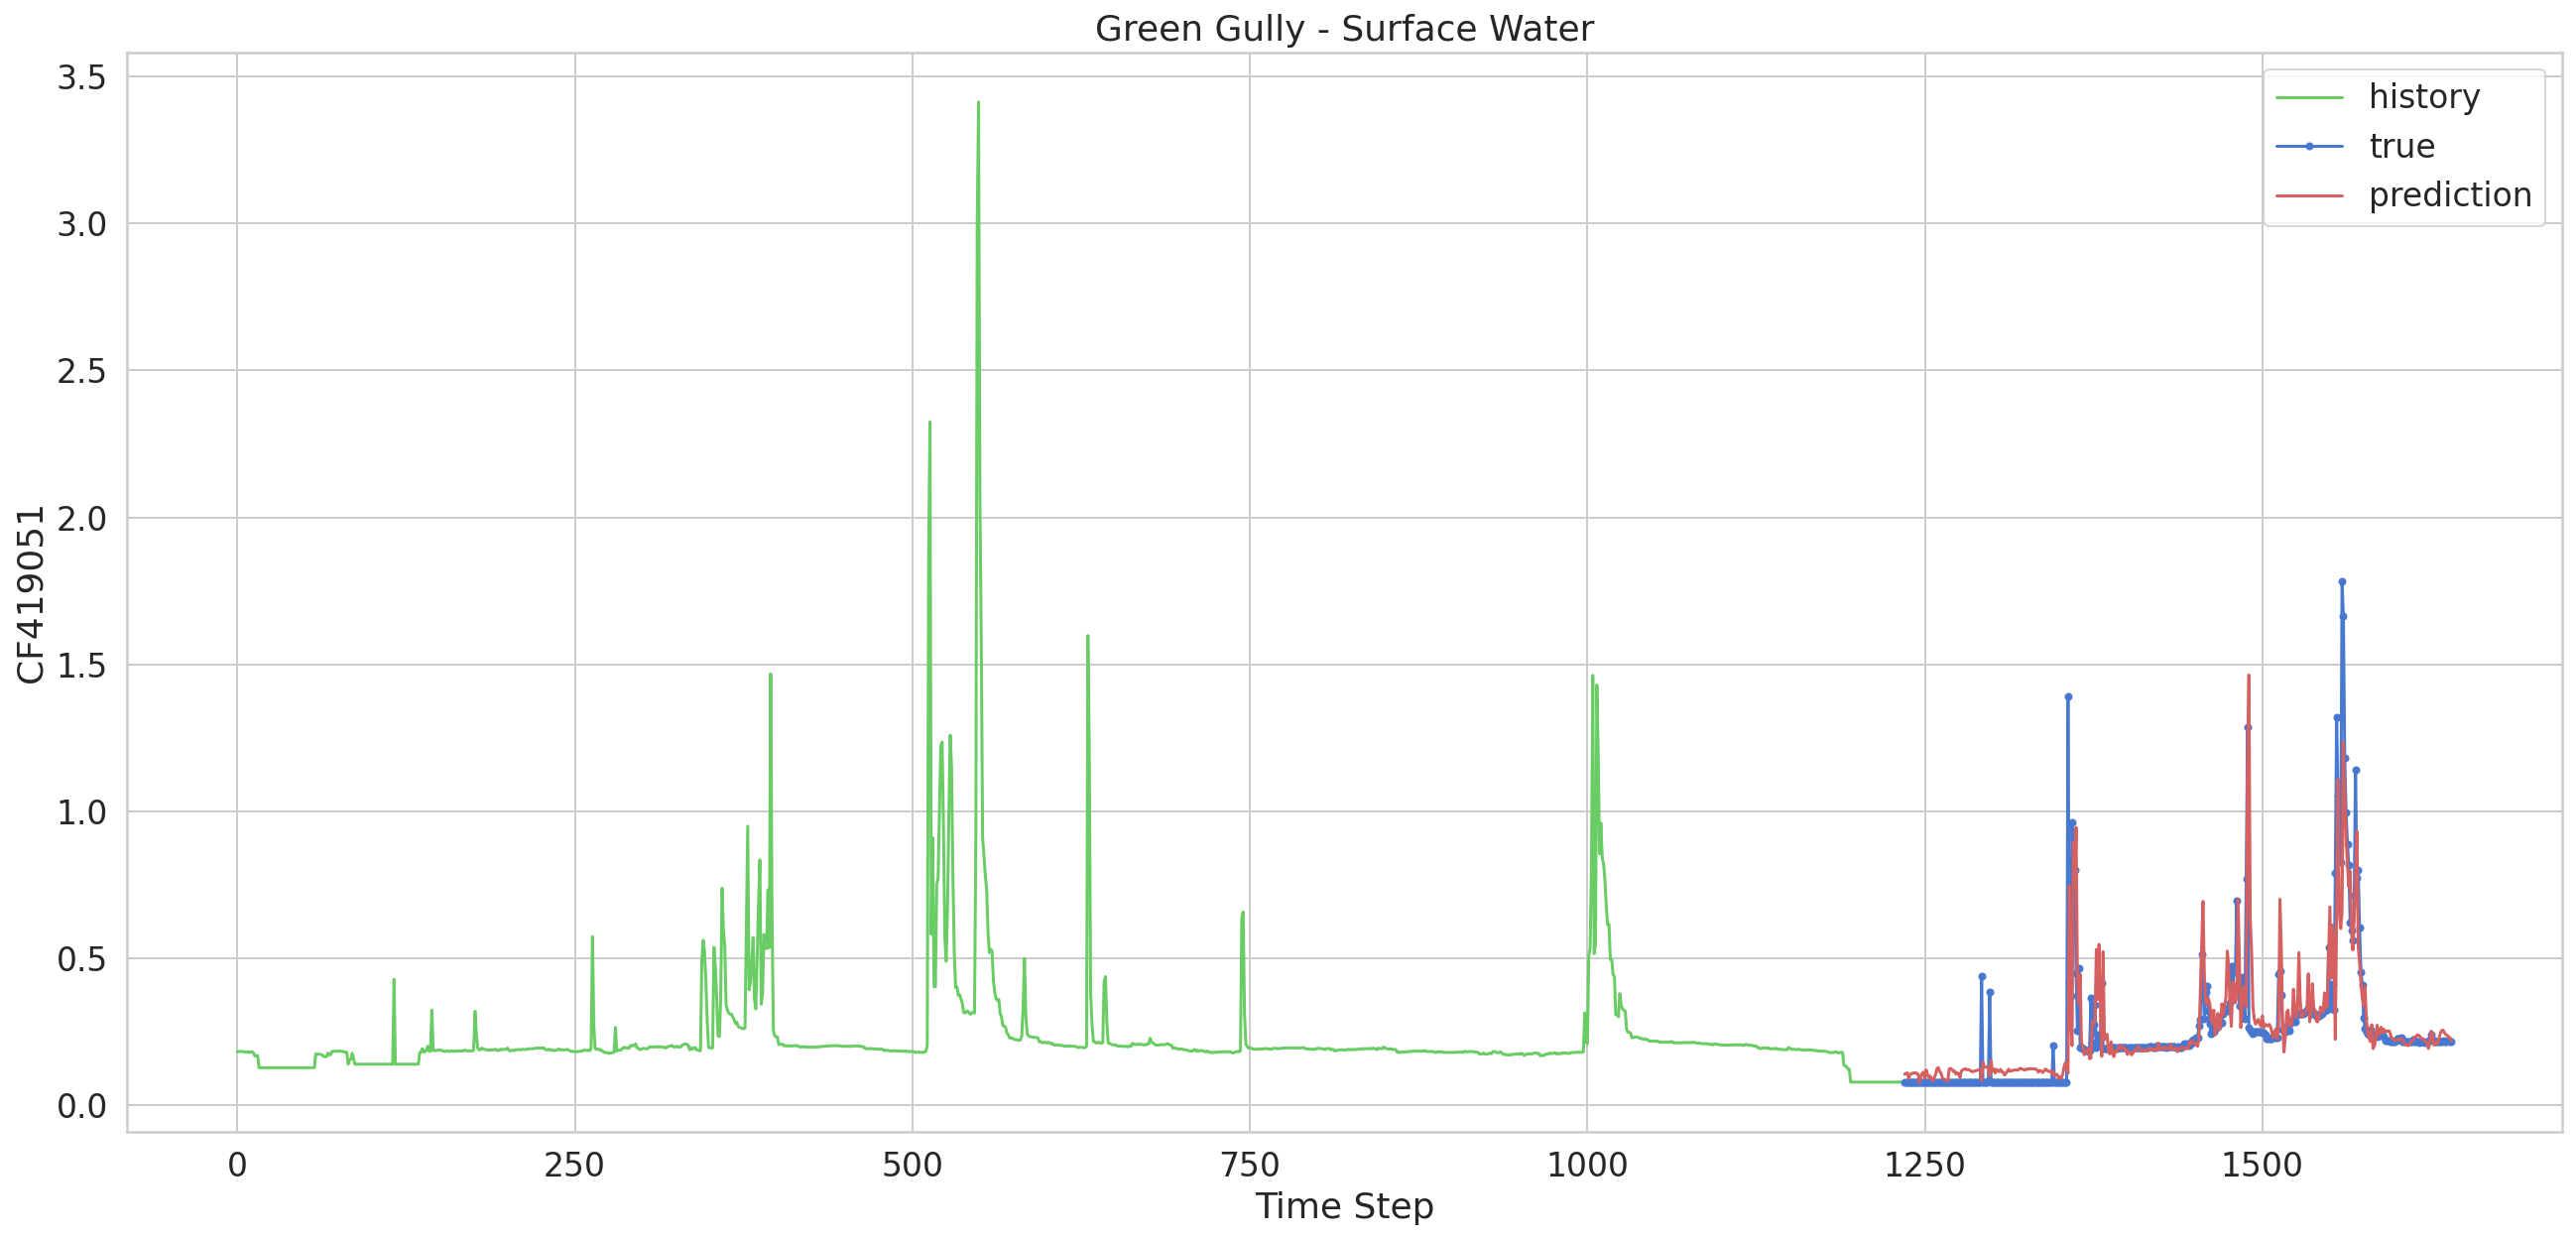

In [21]:
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('CF419051')
plt.xlabel('Time Step')
plt.title('Green Gully - Surface Water')
plt.legend()
plt.show();

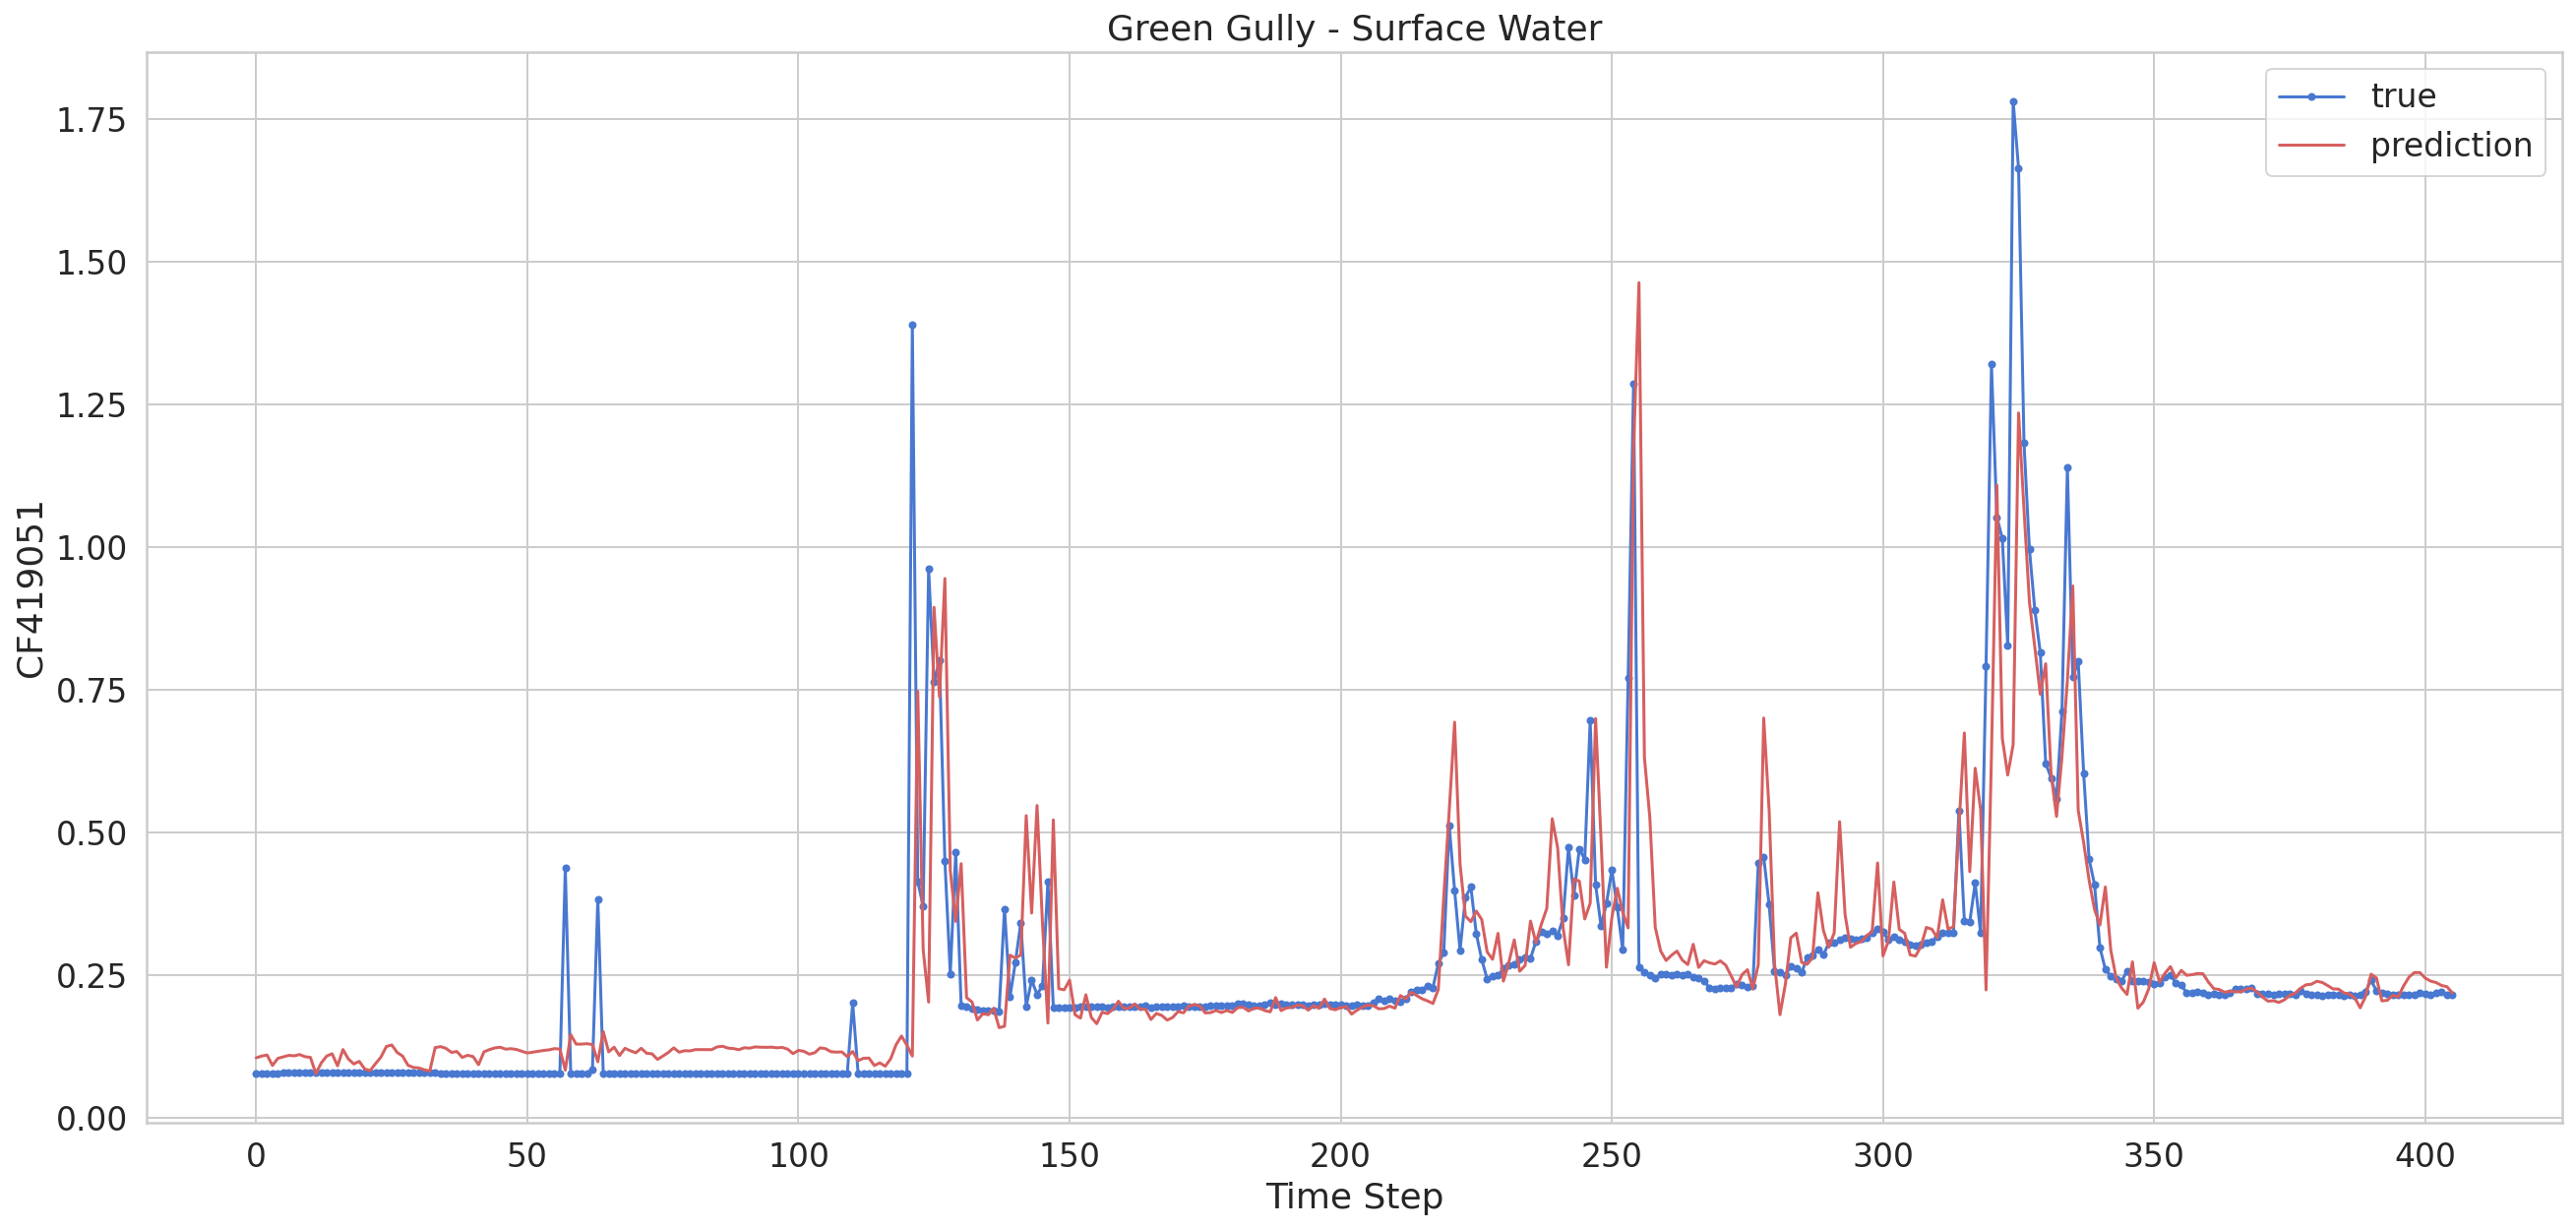

In [22]:
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('CF419051')
plt.xlabel('Time Step')
plt.title('Green Gully - Surface Water')
plt.legend()
plt.show();

In [23]:
fname = '/home/jovyan/work/model/training_data/sw_modelled_training_data.csv'
np.savetxt(fname, y_pred_inv, fmt='%f', delimiter=' ', newline='\n', header='sf_read1', footer='', comments='', encoding=None)